In [1]:
from PIL import Image
import numpy as np
import cupy as cp
from scipy import misc
from matplotlib import pyplot, cm
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice with given pitch."""
    indices = cp.arange(res)
    return (indices - res/2 + 0.5) * pitch

def compute_intervals(res, pitch):
    """Return an array of shape (res+1) containing the boundaries of each sampling cell."""
    indices = cp.arange(res+1)
    return (indices - res/2) * pitch

def compute_indices(x, res, pitch):
    """Return indices for given coordinates with respect to given resolution and pitch."""
    return cp.floor(x / pitch + res/2).astype(cp.int32)

def ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the coordinates on the retina corresponding to the given coordinates on planes A and B."""
    return (x_a * (1.0 - z_b/z_f) - x_b * (1.0 - z_a/z_f)) * (z_r / (z_a - z_b))

def ra_to_p(x_r, x_a, z_r, z_a, z_f):
    """Return the coordinates on the pupil corresponding to the given coordinates on plane A and on the retina."""
    return (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)

def take_2d(values, idx_x, idx_y):
    """Return values at the cartesian product of given indices. Out of bounds are filled with 0."""
    clipped_idx_x = cp.clip(idx_x, -1, values.shape[0]) + 1
    clipped_idx_y = cp.clip(idx_y, -1, values.shape[1]) + 1
    return np.pad(values.get(), 1, mode='constant')[clipped_idx_x.get(),][..., clipped_idx_y.get()]

def compute_imaging_tensor(x_r, ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter):
    """Return the flatland imaging tensor with shape (res_r, res_a, res_b)."""
    # Project intervals to the pupil
    ivl_a_at_p = ra_to_p(x_r[..., np.newaxis, np.newaxis], ivl_a, z_r, z_a, z_f)
    ivl_b_at_p = ra_to_p(x_r[..., np.newaxis, np.newaxis], ivl_b, z_r, z_b, z_f)
    # Bounds imposed by the pupil aperture
    lower_bound = -pupil_diameter/2
    upper_bound =  pupil_diameter/2
    # Restrict plane A intervals to the pupil aperture
    ivl_pa = cp.clip(ivl_a_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture and plane A intervals together
    lower_bound = cp.minimum(ivl_pa[..., :-1, :], ivl_pa[..., 1:, :])
    upper_bound = cp.maximum(ivl_pa[..., :-1, :], ivl_pa[..., 1:, :])
    # Restrict plane B intervals to the pupil aperture and plane A intervals
    ivl_pab = cp.clip(ivl_b_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture, plane A intervals and plane B intervals together
    lower_bound = cp.minimum(ivl_pab[..., :-1], ivl_pab[..., 1:])
    upper_bound = cp.maximum(ivl_pab[..., :-1], ivl_pab[..., 1:])
    # Return the lengths of the intervals normalized by the pupil diameter
    return cp.subtract(upper_bound, lower_bound) / pupil_diameter

def apply_imaging_tensor(img_tsr, signal_ab):
    """Return the image formed by the given imaging tensor over the given light field."""
    return cp.tensordot(img_tsr, signal_ab, axes=((-1, -2), (-1, -2)))

def convolution_matrix(x_in, x_out, kernel):
    """Return a convolution matrix with given kernel."""
    return kernel(x_out[..., np.newaxis] - x_in)

def sinusoidal_signal(x, frequency, phase=0.0):
    """Sample a cosine with given frequency and phase at given sampling coordinates."""
    return cp.cos((x * frequency + phase) * 2 * np.pi)/2 + 0.5

def band_signal(x, thickness):
    """Return a signal composed of a single centered band with given thickness."""
    return (cp.abs(x) < thickness) * 1.0

def decimate_lf(signal_ab, factor):
    """Return the light field decimated by the given factor."""
    return signal_ab[factor//2::factor, factor//2::factor, factor//2::factor, factor//2::factor]

def create_filter(omega_a, omega_b, z_r, z_a, z_b, z_near, z_far, xi_r, xi_p=0.0):
    """Return the filter defined from near and far focus distance and maximum frequency at the retina."""
    mask_near = (z_near * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) < 0
    mask_far = (z_far * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) > 0
    mask_depth = cp.logical_not(cp.logical_xor(mask_near, mask_far))
    mask_p_near = cp.abs((1 - z_a/z_near) * omega_a + (1 - z_b/z_near) * omega_b) < xi_p
    mask_p_far = cp.abs((1 - z_a/z_far) * omega_a + (1 - z_b/z_far) * omega_b) < xi_p
    mask_p = cp.logical_or(mask_p_near, mask_p_far)
    mask_r = cp.abs(z_a * omega_a + z_b * omega_b) < abs(z_r) * xi_r
    return cp.logical_and(mask_r, cp.logical_or(mask_depth, mask_p)) * 1.0

def tile_lf(signal_ab):
    """Return a 2-dim tiling of 2-dim images from given 4-dim light field."""
    return signal_ab.reshape(np.prod(signal_ab.shape[0:2]), -1)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values)
    uint8_values = (color_values * 255).astype(np.uint8)
    display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

In [3]:
z_r = -17.0
z_a = 10.0
z_b = 30.0
z_near = 50.0
z_far = np.inf

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 576
res_a = 24
res_b = 24
supersampling = 3 # This value must be an odd number!

res_lf = (res_a * supersampling, res_b * supersampling, res_a * supersampling, res_b * supersampling)

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

xi_r = 0.5 / pitch_r
xi_a = 0.5 / pitch_a
xi_b = 0.5 / pitch_b

In [4]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

x_r = compute_coordinates(res_r, pitch_r)
omega_r =  cp.fft.fftfreq(res_r, pitch_r)

x_a = compute_coordinates(res_a, pitch_a)[    ::    , np.newaxis]
omega_a =  cp.fft.fftfreq(res_a, pitch_a)[    ::    , np.newaxis]

x_b = compute_coordinates(res_b, pitch_b)[np.newaxis,     ::    ]
omega_b =  cp.fft.fftfreq(res_b, pitch_b)[np.newaxis,     ::    ]

x_a_sup = compute_coordinates(res_a*supersampling, pitch_a/supersampling)[    ::    , np.newaxis]
omega_a_sup =  cp.fft.fftfreq(res_a*supersampling, pitch_a/supersampling)[    ::    , np.newaxis]

x_b_sup = compute_coordinates(res_b*supersampling, pitch_b/supersampling)[np.newaxis,     ::    ]
omega_b_sup =  cp.fft.fftfreq(res_b*supersampling, pitch_b/supersampling)[np.newaxis,     ::    ]

ivl_a = compute_intervals(res_a, pitch_a)[    ::    , np.newaxis]
ivl_b = compute_intervals(res_b, pitch_b)[np.newaxis,     ::    ]

ivl_a_sup = compute_intervals(res_a*supersampling, pitch_a/supersampling)[    ::    , np.newaxis]
ivl_b_sup = compute_intervals(res_b*supersampling, pitch_b/supersampling)[np.newaxis,     ::    ]

result = np.zeros((res_r * 2, res_r * 2))

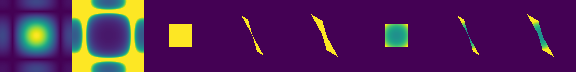

In [5]:
sinc_filter = cp.sinc(omega_a_sup * pitch_a) * cp.sinc(omega_b_sup * pitch_b)
unsinc_filter = cp.clip(cp.nan_to_num(cp.reciprocal(sinc_filter)), -16.0, 16.0)

box_filter = cp.logical_and(cp.abs(omega_a_sup) < xi_a, cp.abs(omega_b_sup) < xi_b) * 1.0
thin_hg_filter = create_filter(omega_a_sup, omega_b_sup, z_r, z_a, z_b, z_near, z_far, 1.6)
thick_hg_filter = create_filter(omega_a_sup, omega_b_sup, z_r, z_a, z_b, z_near, z_far, 1.6, 0.2)

display_image(cp.vstack((cp.fft.fftshift(cp.abs(sinc_filter)),
                         cp.fft.fftshift(cp.abs(unsinc_filter)/16.0),
                         cp.fft.fftshift(box_filter),
                         cp.fft.fftshift(thin_hg_filter),
                         cp.fft.fftshift(thick_hg_filter),
                         cp.fft.fftshift(box_filter * unsinc_filter * 0.5),
                         cp.fft.fftshift(thin_hg_filter * unsinc_filter * 0.5),
                         cp.fft.fftshift(thick_hg_filter * unsinc_filter * 0.5) )).get(), False)

filters = [cp.atleast_2d(1.0), box_filter, thin_hg_filter, thick_hg_filter]

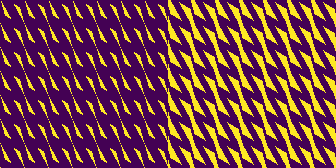

In [6]:
thin_spectrum = cp.abs(cp.fft.fft2(cp.fft.ifft2(thin_hg_filter)[supersampling//2::supersampling, supersampling//2::supersampling]))
thick_spectrum = cp.abs(cp.fft.fft2(cp.fft.ifft2(thick_hg_filter)[supersampling//2::supersampling, supersampling//2::supersampling]))

display_image(cp.vstack((cp.tile(thin_spectrum/cp.amax(thin_spectrum), (7, 7)),
                         cp.tile(thick_spectrum/cp.amax(thick_spectrum), (7, 7)))).get())

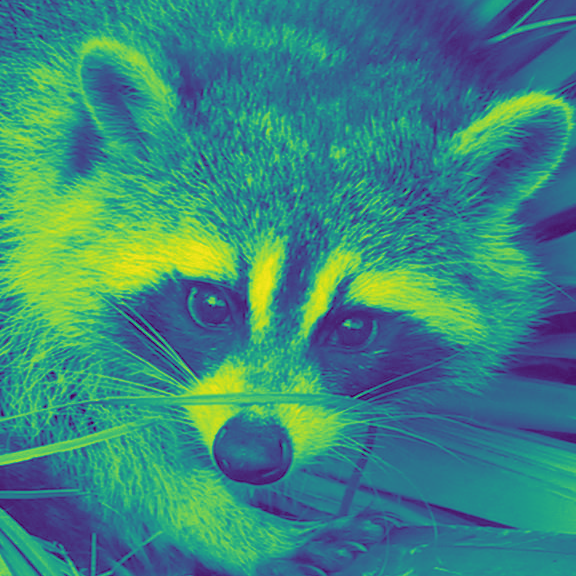

In [7]:
retinal_image = cp.asarray(misc.face(True).T[-656:-80, 576:0:-1]) / 255
display_image(retinal_image.get())

In [8]:
z_f = 100.0

img_tsr_sup = compute_imaging_tensor(x_r, ivl_a_sup, ivl_b_sup, z_r, z_a, z_b, z_f, pupil_diameter)
img_tsr = compute_imaging_tensor(x_r, ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter)

x_r_over_ab_sup = ab_to_r(x_a_sup, x_b_sup, z_r, z_a, z_b, z_f)
idx_r_over_ab_sup = compute_indices(x_r_over_ab_sup, res_r, pitch_r)
signal_ab_sup = take_2d(retinal_image, idx_r_over_ab_sup, idx_r_over_ab_sup)

print(signal_ab_sup.nbytes/2**30)

#display_image(np.flip(tile_lf(signal_ab_sup).get()))
#display_image(apply_imaging_tensor(img_tsr_sup, apply_imaging_tensor(img_tsr_sup, signal_ab_sup)).get())

#spectrum_sup = cp.fft.fftn(signal_ab_sup)

0.200225830078125


In [9]:
spectrum_sup = cp.fft.fftn(signal_ab_sup)

AttributeError: 'memoryview' object has no attribute 'ptr'

In [ ]:
z_f = 100.0

img_tsr_sup = compute_imaging_tensor(x_r, ivl_a_sup, ivl_b_sup, z_r, z_a, z_b, z_f, pupil_diameter)
img_tsr = compute_imaging_tensor(x_r, ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter)

x_r_over_ab_sup = ab_to_r(x_a_sup, x_b_sup, z_r, z_a, z_b, z_f)
idx_r_over_ab_sup = compute_indices(x_r_over_ab_sup, res_r, pitch_r)
signal_ab_sup = take_2d(retinal_image, idx_r_over_ab_sup, idx_r_over_ab_sup)

display_image(np.flip(tile_lf(signal_ab_sup).get()))
display_image(apply_imaging_tensor(img_tsr_sup, apply_imaging_tensor(img_tsr_sup, signal_ab_sup)).get())

spectrum_sup = cp.fft.fftn(signal_ab_sup)

for filter_kernel in filters:
    spectrum_filtered = (spectrum_sup.T * filter_kernel.T).T * filter_kernel
    print(mempool.used_bytes(), mempool.used_bytes()/2**30)
    signal_filtered = cp.real(cp.fft.ifftn(spectrum_filtered))
    print(mempool.used_bytes(), mempool.used_bytes()/2**30)
    signal_filtered = cp.maximum(decimate_lf(signal_filtered, supersampling), 0.0)
    print(mempool.used_bytes(), mempool.used_bytes()/2**30)
    result[:res_r, res_r:] = np.flip(tile_lf(signal_filtered).get())
    result[:res_r, :res_r] = apply_imaging_tensor(img_tsr, apply_imaging_tensor(img_tsr, signal_filtered)).get()

    spectrum_unsinc = (spectrum_filtered.T * unsinc_filter.T).T * unsinc_filter
    signal_unsinc = cp.maximum(decimate_lf(cp.real(cp.fft.ifftn(spectrum_unsinc)), supersampling), 0.0)
    result[res_r:, res_r:] = np.flip(tile_lf(signal_unsinc).get())
    result[res_r:, :res_r] = apply_imaging_tensor(img_tsr, apply_imaging_tensor(img_tsr, signal_unsinc)).get()

    display_image(result, False)

In [ ]:
z_f = 20.0

img_tsr_sup = compute_imaging_tensor(x_r, ivl_a_sup, ivl_b_sup, z_r, z_a, z_b, z_f, pupil_diameter)
img_tsr = compute_imaging_tensor(x_r, ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter)

x_r_over_ab_sup = ab_to_r(x_a_sup, x_b_sup, z_r, z_a, z_b, z_f)
idx_r_over_ab_sup = compute_indices(x_r_over_ab_sup, res_r, pitch_r)
signal_ab_sup = take_2d(retinal_image, idx_r_over_ab_sup, idx_r_over_ab_sup)

display_image(np.flip(tile_lf(signal_ab_sup).get()))
display_image(apply_imaging_tensor(img_tsr_sup, apply_imaging_tensor(img_tsr_sup, signal_ab_sup)).get())

spectrum_sup = cp.fft.fftn(signal_ab_sup)

for filter_kernel in filters:
    spectrum_filtered = (spectrum_sup.T * filter_kernel.T).T * filter_kernel
    signal_filtered = cp.maximum(decimate_lf(cp.real(cp.fft.ifftn(spectrum_filtered)), supersampling), 0.0)
    result[:res_r, res_r:] = np.flip(tile_lf(signal_filtered).get())
    result[:res_r, :res_r] = apply_imaging_tensor(img_tsr, apply_imaging_tensor(img_tsr, signal_filtered)).get()

    spectrum_unsinc = (spectrum_filtered.T * unsinc_filter.T).T * unsinc_filter
    signal_unsinc = cp.maximum(decimate_lf(cp.real(cp.fft.ifftn(spectrum_unsinc)), supersampling), 0.0)
    result[res_r:, res_r:] = np.flip(tile_lf(signal_unsinc).get())
    result[res_r:, :res_r] = apply_imaging_tensor(img_tsr, apply_imaging_tensor(img_tsr, signal_unsinc)).get()

    display_image(result, False)